<a href="https://colab.research.google.com/github/zrosen3/Colombian-peso-counterfeit-detection/blob/main/Code/hybrid_cnns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Load libraries

In [ ]:
#Set up google colab working environment
%cd ~/../content
%rm -rf Colombian-peso-counterfeit-detection
!git clone https://github.com/zrosen3/Colombian-peso-counterfeit-detection.git 
%cd /content/Colombian-peso-counterfeit-detection/Code       

/content
Cloning into 'Colombian-peso-counterfeit-detection'...
remote: Enumerating objects: 42270, done.
remote: Counting objects: 100% (96/96), done.
remote: Compressing objects: 100% (78/78), done.
remote: Total 42270 (delta 67), reused 25 (delta 18), pack-reused 42174
Receiving objects: 100% (42270/42270), 883.49 MiB | 26.03 MiB/s, done.
Resolving deltas: 100% (1226/1226), done.
Updating files: 100% (103997/103997), done.
/content/Colombian-peso-counterfeit-detection/Code


In [ ]:
import matplotlib.pyplot as plt #For plotting our visualizations
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
import cv2
from PIL import Image
import seaborn as sns
import common_functions as cf
import xgboost as xgb



#Load in data

In [ ]:
train_ds, test_ds, validation_ds, class_names = cf.LoadData(path = "../Data/Augmented/", batch_size=12)


Found 24958 files belonging to 13 classes.
Found 8320 files belonging to 13 classes.
Found 8320 files belonging to 13 classes.


## Create ensemble of CNNs


Define CNN model function

In [ ]:
def CNNModel(class_names:str,  conv_layers: list = [32], layers: list = [], learning_rate: float = 0.001, dropout: float = 0.5) -> tf.keras.Sequential:
    """
    Simple straight forward CNN model. this is just for simplicity and testing
    atm. I will make it more modular later once I know what we are doing
    Args:
        class_names: list of the classification names
        conv_layers: list of how many filters each convolutional layer should use
        layers: list with the sizes of each hidden layer
        learning_rate: the learning rate for the optimizer
        dropout: the dropout rate for the model
    Returns:
        `tf.keras.Sequential` - a constructed tf model
    """
    tf.keras.backend.clear_session()

    model = tf.keras.Sequential(name = str(i))
    model.add(tf.keras.layers.Rescaling(1./255))
    for filter_count in conv_layers:
        model.add(tf.keras.layers.Conv2D(filter_count, 3, activation='relu'))
        model.add(tf.keras.layers.MaxPooling2D())
    model.add(tf.keras.layers.Flatten())
    for layer_count in layers:
        model.add(tf.keras.layers.Dense(layer_count, activation='relu'))
    model.add(tf.keras.layers.Dropout(rate=dropout))
    model.add(tf.keras.layers.Dense(len(class_names), activation = 'softmax'))
    model.compile(
      optimizer='adam',
      loss='sparse_categorical_crossentropy',
      metrics=['accuracy'])
    model.fit(
      train_ds,
      validation_data=validation_ds,
      epochs=5)

    return model


Initialize multiple CNNs

In [ ]:
#Initialize keras session
tf.keras.backend.clear_session()
np.random.seed(0)
tf.random.set_seed(0)
#List parameters for different CNNs
models_config = [
  {'conv_layers': [32], 'layers': []},
  {'conv_layers' : [32, 64], 'layers' : [64, 128]},
  {'conv_layers' : [32, 64], 'layers' : [64, 128, 256]},
]

#Create different models
models = []
for i, config in enumerate(models_config):
    # Create a CNN model with the current configuration
    model = CNNModel(class_names, **config)
    models.append(model)

Epoch 1/5
780/780 [==============================] - 48s 60ms/step - loss: 2.3533 - accuracy: 0.6889 - val_loss: 0.3685 - val_accuracy: 0.8980
Epoch 2/5
780/780 [==============================] - 47s 60ms/step - loss: 0.2039 - accuracy: 0.9546 - val_loss: 0.1759 - val_accuracy: 0.9534
Epoch 3/5
780/780 [==============================] - 47s 60ms/step - loss: 0.0790 - accuracy: 0.9801 - val_loss: 0.1105 - val_accuracy: 0.9686
Epoch 4/5
780/780 [==============================] - 47s 60ms/step - loss: 0.0673 - accuracy: 0.9822 - val_loss: 0.1243 - val_accuracy: 0.9617
Epoch 5/5
780/780 [==============================] - 47s 60ms/step - loss: 0.0586 - accuracy: 0.9840 - val_loss: 0.1341 - val_accuracy: 0.9613
Epoch 1/5
780/780 [==============================] - 60s 75ms/step - loss: 1.4448 - accuracy: 0.4986 - val_loss: 0.3663 - val_accuracy: 0.8712
Epoch 2/5
780/780 [==============================] - 58s 75ms/step - loss: 0.2774 - accuracy: 0.9086 - val_loss: 0.1956 - val_accuracy: 0.9352

Create ensemble model 

In [ ]:
input_layer = tf.keras.layers.Input(shape=(480, 640, 3))  
outputs = []
for i,model in enumerate(models):
    model._name = str(i)
    output = model(input_layer)
    outputs.append(output)
averaged_outputs = tf.reduce_mean(outputs, axis = 0)
output_layer = tf.keras.layers.Dense(13, activation='softmax')(averaged_outputs)  
ensemble_model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

Fit ensemble model

In [ ]:
#Fit ensemble model 
ensemble_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

history = ensemble_model.fit(
  train_ds,
  validation_data=validation_ds,
  epochs=5)

Epoch 1/5
780/780 [==============================] - 105s 127ms/step - loss: 2.0183 - accuracy: 0.6066 - val_loss: 1.6408 - val_accuracy: 0.7067
Epoch 2/5
780/780 [==============================] - 99s 127ms/step - loss: 1.3380 - accuracy: 0.6799 - val_loss: 1.1470 - val_accuracy: 0.6442
Epoch 3/5
780/780 [==============================] - 99s 127ms/step - loss: 0.9757 - accuracy: 0.7365 - val_loss: 0.9134 - val_accuracy: 0.7581
Epoch 4/5
780/780 [==============================] - 99s 127ms/step - loss: 0.8130 - accuracy: 0.7805 - val_loss: 1.0926 - val_accuracy: 0.7450
Epoch 5/5
780/780 [==============================] - 99s 127ms/step - loss: 1.2121 - accuracy: 0.6961 - val_loss: 0.9419 - val_accuracy: 0.7399


## Inspect model performance

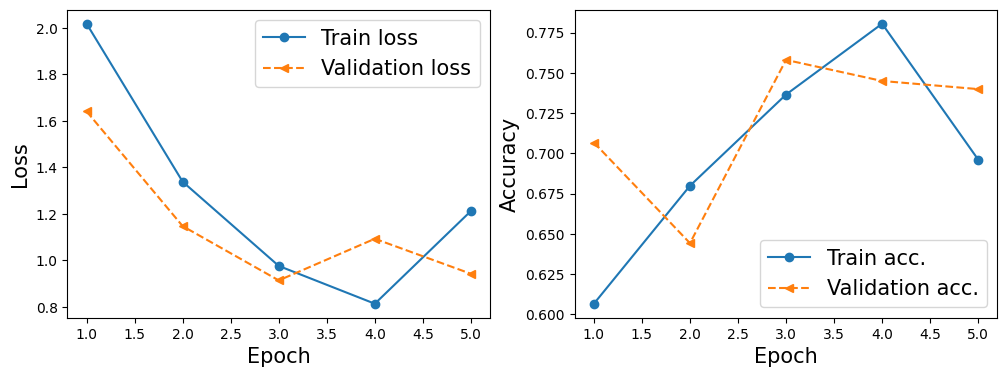

260/260 - 15s - loss: 0.9440 - accuracy: 0.7415 - 15s/epoch - 56ms/step
Test loss: 0.9439535737037659 | Test accuracy: 0.7414663434028625


(0.6961295008659363, 0.7399038672447205, 0.7414663434028625)

In [ ]:
cf.EvaluateModel(ensemble_model, test_ds, history)


Macro averaged precision score: 0.7414663461538461
Macro averaged recall score: 0.718265847117868
Macro averaged F1 score: 0.688108443168768


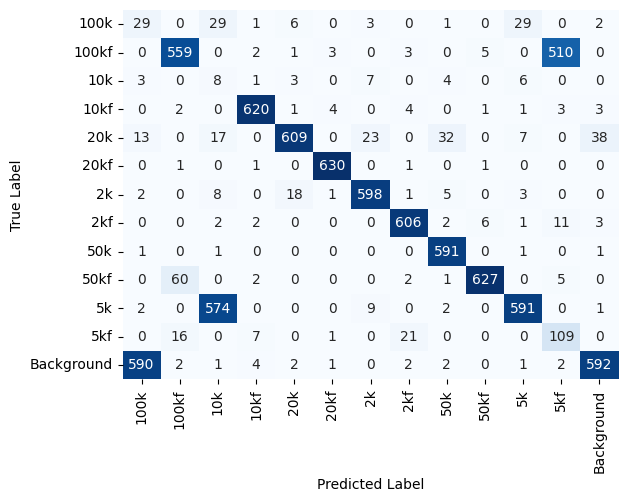

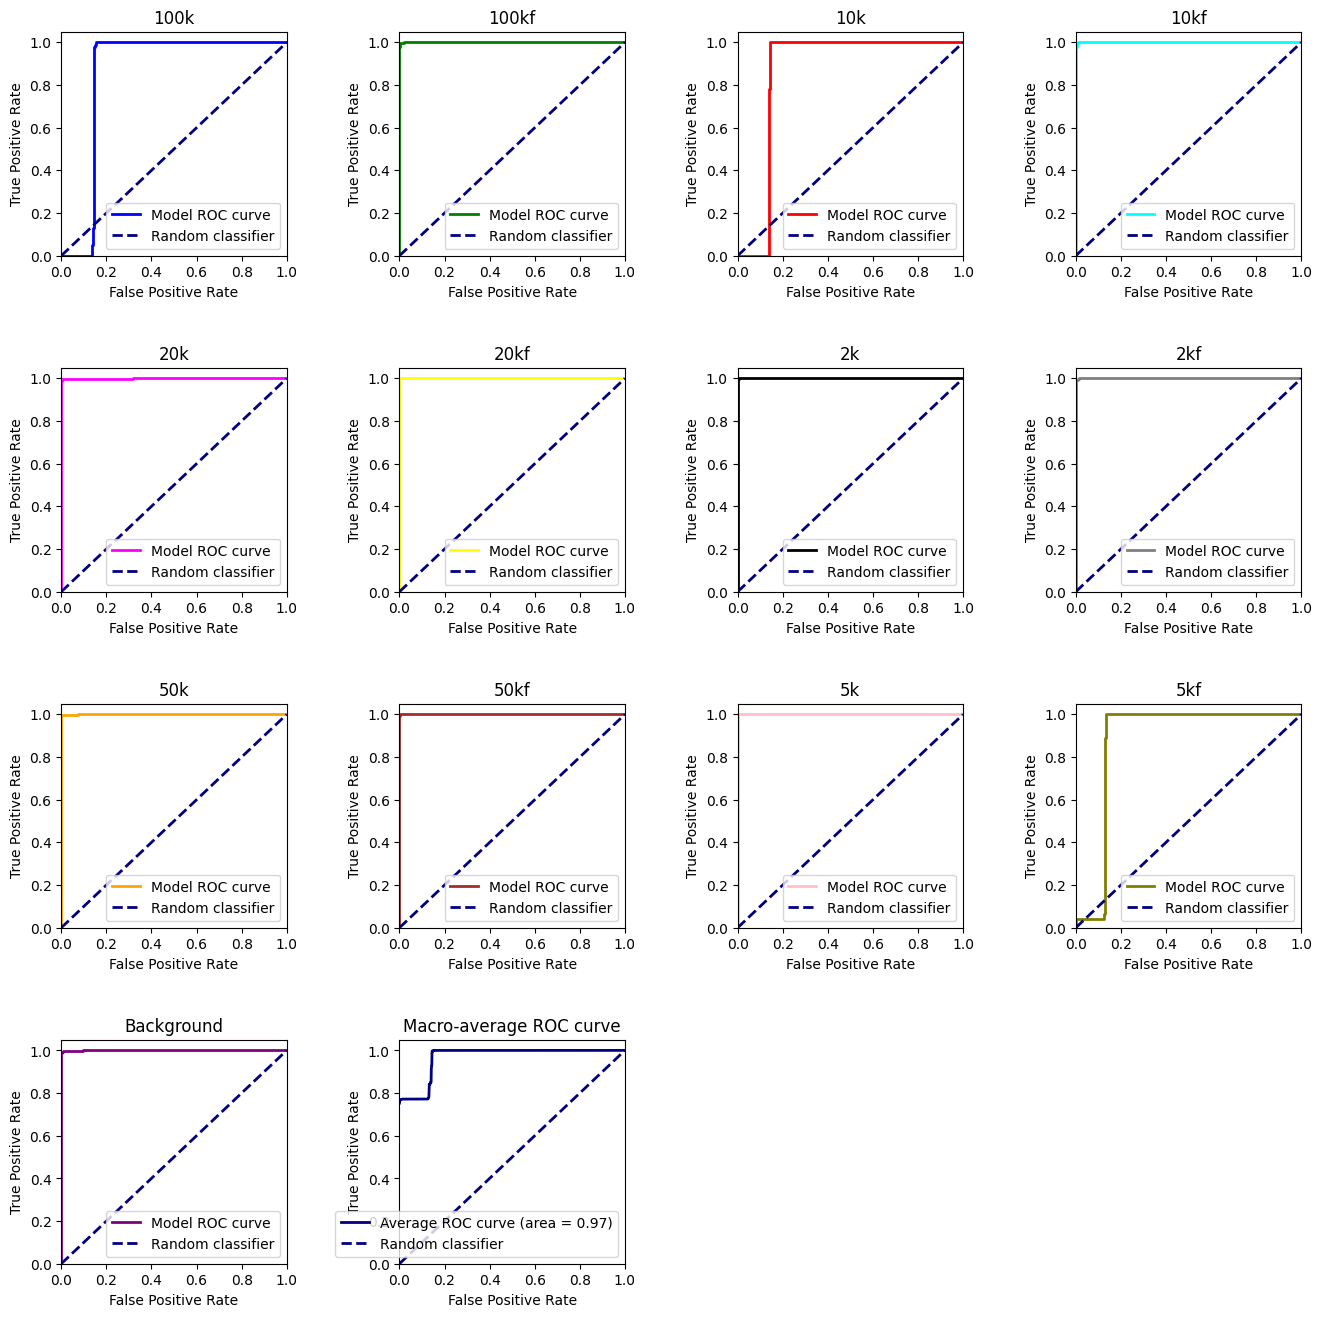

In [ ]:
cf.precision_recall_metrics(ensemble_model, test_ds, class_names)